In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
from collections import OrderedDict
from transformers import AutoTokenizer

device = "cuda"
torch.cuda.set_device(device)

c:\Users\chris\anaconda3\envs\llmbook\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Llama 2 from Scratch

In [2]:
lines = open('../../data/tiny_shakespeare.txt', 'r', encoding='utf-8').read()

In [3]:
tokenizer = AutoTokenizer.from_pretrained("./llama2/")

vocab = tokenizer.vocab

In [4]:
def encode(example):
    return tokenizer.encode(example, max_length=256, truncation=True, return_tensors="pt")

def decode(example):
    return tokenizer.batch_decode(example)[0]

print(f"Vocab Size: {len(vocab)}")
decode(encode("hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions"))

Vocab Size: 32000


'<s> hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions'

In [49]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
    "batch_size": 16,
    "context_window": 32,
    "d_model": 288,
    "hidden_dim": 768,
    "epochs": 1000,
    "log_interval": 50,
    "n_heads": 6,
    "n_layers": 6,
}

In [6]:
dataset = torch.tensor(tokenizer.encode(lines))
dataset.shape

torch.Size([368634])

### Needed functions

In [7]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG, debug=False):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]
    
    batch_data = train
    if split == 'val':
        batch_data = val

    if split == 'test':
        batch_data = test
    
    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    if debug:
        print(f"ix: {ix}\nx: {x}\ny: {y}")
    return x, y

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], debug=False)

[(decode(xs[i:i+MASTER_CONFIG['batch_size']]), decode(ys[i:i+MASTER_CONFIG['batch_size']])) for i in range(len(xs))]

[("the determined respite of my wrongs:\nThat high All-Seer that I dallied with\nHath turn'd my feigned prayer on",
  "determined respite of my wrongs:\nThat high All-Seer that I dallied with\nHath turn'd my feigned prayer on my"),
 ('art.\nNow must I hide his body in some hole,\nUntil the duke take order for his burial:\nAnd when I have my',
  '.\nNow must I hide his body in some hole,\nUntil the duke take order for his burial:\nAnd when I have my me'),
 (',\nOr any other ground inhabitable,\nWhere ever Englishman durst set his foot.\nMean time let this defend my loyalty,\n',
  '\nOr any other ground inhabitable,\nWhere ever Englishman durst set his foot.\nMean time let this defend my loyalty,\nBy'),
 ('his party.\n\nKING RICHARD II:\nThou hast said enough.\nBeshrew thee, cousin, which didst lead',
  'party.\n\nKING RICHARD II:\nThou hast said enough.\nBeshrew thee, cousin, which didst lead me'),
 ("'t;\nProvided that, when he's removed, your highness\nWill take again your queen as yo

In [8]:
@torch.no_grad()
def get_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ['train','val']:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

@torch.inference_mode()
def generate(model, config=MASTER_CONFIG, temperature=1.0, top_k=None, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        
        last_time_step_logits = last_time_step_logits / temperature
        if top_k is not None:
            v, _ = torch.topk(last_time_step_logits, min(top_k, last_time_step_logits.size(-1)))
            last_time_step_logits[last_time_step_logits < v[:,[-1]]] = -float('Inf')
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [tokenizer.decode(x) for x in idx.tolist()]

### Gross neural network that doesn't work

In [9]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config
        
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )
        
        print(f"model params: {sum([m.numel() for m in self.parameters()])}")
        
    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)
        
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        
        else:
            return logits
        
model = SimpleFeedForwardNN(MASTER_CONFIG).to(device)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)

model params: 18547232


### Training Loop

In [10]:
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()
        
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
            
        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = get_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds: {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()
            
            if scheduler:
                print("lr: ", scheduler.get_lr())
            
    print(f"validation loss: {losses[-1]['val']}")
    return pd.DataFrame(losses).plot()

Epoch 0 | val loss 10.317 | Time 0.137 | ETA in seconds: 2.740
Epoch 50 | val loss 6.294 | Time 6.969 | ETA in seconds: 132.410
Epoch 100 | val loss 5.744 | Time 6.972 | ETA in seconds: 125.496
Epoch 150 | val loss 5.491 | Time 6.799 | ETA in seconds: 115.583
Epoch 200 | val loss 5.424 | Time 6.817 | ETA in seconds: 109.072
Epoch 250 | val loss 5.421 | Time 6.884 | ETA in seconds: 103.260
Epoch 300 | val loss 5.405 | Time 6.916 | ETA in seconds: 96.824
Epoch 350 | val loss 5.072 | Time 6.926 | ETA in seconds: 90.038
Epoch 400 | val loss 5.146 | Time 6.745 | ETA in seconds: 80.940
Epoch 450 | val loss 5.258 | Time 6.852 | ETA in seconds: 75.372
Epoch 500 | val loss 4.985 | Time 6.717 | ETA in seconds: 67.170
Epoch 550 | val loss 5.195 | Time 6.807 | ETA in seconds: 61.263
Epoch 600 | val loss 5.147 | Time 6.871 | ETA in seconds: 54.968
Epoch 650 | val loss 5.131 | Time 6.850 | ETA in seconds: 47.950
Epoch 700 | val loss 5.214 | Time 6.887 | ETA in seconds: 41.322
Epoch 750 | val loss 4.

<Axes: >

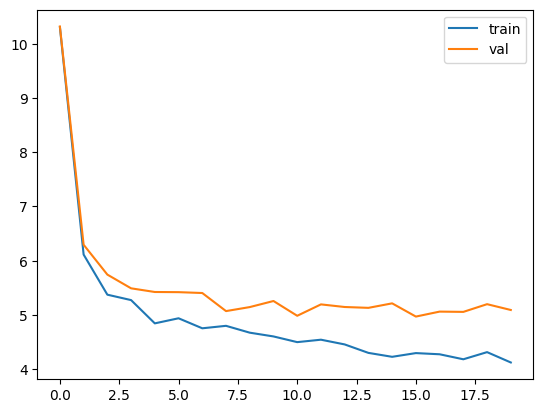

In [11]:
optimizer = torch.optim.AdamW(
    model.parameters(),
)
train(model, optimizer, print_logs=True)

In [12]:
generate(model, config=MASTER_CONFIG)

['<unk> wild\nWhen I nor.\n\nMER:\n\nThat thou advantage me on the queen, my end four glory but if the good old',
 "<unk>'d from it so soon,\nBRUTUS:\nISABETHis foul the yonder and am for our wife,\n",
 '<unk> thou yield, my valiolanus,\n\nBut when weep hide enough.\nIf he came eye\nTo kill thy tongue and comfort',
 "<unk>Dver's, and Россииome me, come for her when it, this Duke of thus my life but like them bust out flexible War",
 "<unk> that have done, sir, they say.\nSpe care of pout'd the have heard the bas bothery\nusves\nEnforce"]

### RMS Normalization

This is as opposed to the original Batch Normalization used in the original transformers paper.
Basically it works by taking 1/sqrt(N) * frobenius_norm

In [13]:
class RMSNormalization(nn.Module):
    def __init__(self, layer_shape, eps=1e-5, bias=False):
        super(RMSNormalization, self).__init__()
        self.eps = eps
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))
        
    def forward(self, x):
        """
        assumes shape (batch, seq_len, d_model)
        """
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw
    
test_batch = torch.randn((5, 11, 13))
m = RMSNormalization((11, 13))
g = m(test_batch)
print(g.shape)

torch.Size([5, 11, 13])


model params: 18556448
Epoch 0 | val loss 10.258 | Time 0.155 | ETA in seconds: 3.100
Epoch 50 | val loss 6.267 | Time 6.843 | ETA in seconds: 130.008
Epoch 100 | val loss 5.741 | Time 6.921 | ETA in seconds: 124.578
Epoch 150 | val loss 5.686 | Time 6.865 | ETA in seconds: 116.697
Epoch 200 | val loss 5.517 | Time 6.917 | ETA in seconds: 110.672
Epoch 250 | val loss 5.363 | Time 6.973 | ETA in seconds: 104.595
Epoch 300 | val loss 5.223 | Time 6.834 | ETA in seconds: 95.677
Epoch 350 | val loss 5.312 | Time 6.875 | ETA in seconds: 89.369
Epoch 400 | val loss 5.101 | Time 6.879 | ETA in seconds: 82.548
Epoch 450 | val loss 5.224 | Time 6.828 | ETA in seconds: 75.109
Epoch 500 | val loss 5.041 | Time 6.956 | ETA in seconds: 69.560
Epoch 550 | val loss 5.253 | Time 6.834 | ETA in seconds: 61.506
Epoch 600 | val loss 5.087 | Time 6.792 | ETA in seconds: 54.336
Epoch 650 | val loss 5.213 | Time 6.808 | ETA in seconds: 47.656
Epoch 700 | val loss 5.284 | Time 6.721 | ETA in seconds: 40.326


<Axes: >

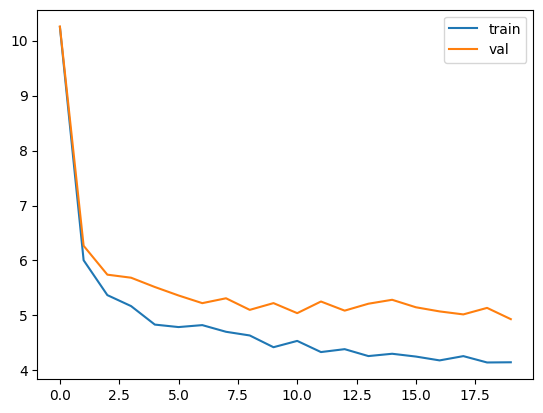

In [14]:
class SimpleFeedForwardNN_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNormalization((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )
        
        print(f"model params: {sum([m.numel() for m in self.parameters()])}")
        
    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x) # rms pre-normalization
        logits = self.linear(x)
        
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        
        else:
            return logits
        
model = SimpleFeedForwardNN_RMS(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, print_logs=True)

In [15]:
generate(model, config=MASTER_CONFIG)

["<unk> he voice: look upon the anch. I amain.'\nAnd pay-place in honestage.'\nToanderor didst prophes,",
 "<unk> only to nands! thy intend to know,\nWithdraw'll entre us; where more Thurs with thee to forth by the good old",
 '<unk> his place, honesty.\nKINGSay how far me,\nL.\n\nAs come, but do be content,\nK',
 '<unk>.\n himself in some noise of recompense of life! S him for leis to your hast\nAll and which of beaver end till',
 '<unk> see what these faint;\n\nMyide Lewis,\nMy lord.\nThe lords of myself\n\nDid hold it you heard,\n']

### RoPE scaling

Rotary Embeddings changes the positional encoding from being based on sine and cosine to being based on the rotation of the embeddings, with a different rotation at each position

In [16]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

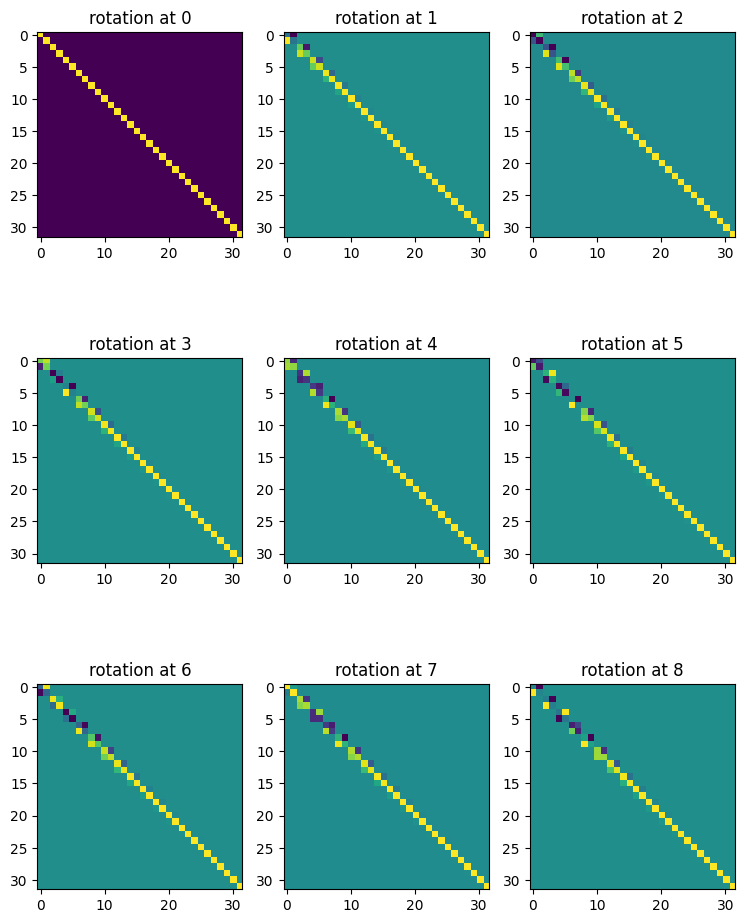

In [17]:
K = 3
config = {
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2,
}
batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

In [18]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])
        
    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i-1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R
    
    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)
        
        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)
        
        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=.1, is_causal=True
        )
        
        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m,m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

layer = RoPEMaskedAttentionHead(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

In [19]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)
        
    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

layer = RoPEMaskedMultiheadAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output = layer(batch)
output.shape

torch.Size([16, 32, 288])

model params: 20547392
Epoch 0 | val loss 10.346 | Time 0.192 | ETA in seconds: 3.840
Epoch 50 | val loss 6.312 | Time 9.176 | ETA in seconds: 174.345
Epoch 100 | val loss 5.952 | Time 9.214 | ETA in seconds: 165.851
Epoch 150 | val loss 5.560 | Time 9.218 | ETA in seconds: 156.699
Epoch 200 | val loss 5.278 | Time 9.199 | ETA in seconds: 147.179
Epoch 250 | val loss 5.376 | Time 9.123 | ETA in seconds: 136.845
Epoch 300 | val loss 5.251 | Time 9.179 | ETA in seconds: 128.507
Epoch 350 | val loss 5.081 | Time 9.180 | ETA in seconds: 119.340
Epoch 400 | val loss 5.118 | Time 9.165 | ETA in seconds: 109.974
Epoch 450 | val loss 5.089 | Time 9.257 | ETA in seconds: 101.827
Epoch 500 | val loss 5.126 | Time 9.227 | ETA in seconds: 92.271
Epoch 550 | val loss 5.054 | Time 9.255 | ETA in seconds: 83.295
Epoch 600 | val loss 4.918 | Time 9.164 | ETA in seconds: 73.312
Epoch 650 | val loss 5.040 | Time 9.207 | ETA in seconds: 64.446
Epoch 700 | val loss 4.863 | Time 9.202 | ETA in seconds: 55.

<Axes: >

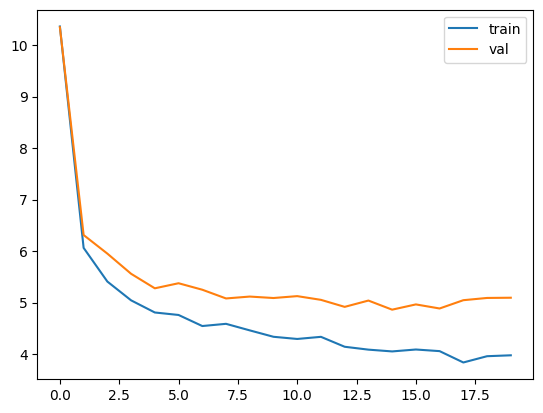

In [20]:
class SimpleFeedForwardNN_RMS_Rope(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNormalization((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)
        
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU() 
        )
        
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])
        
        print(f"model params: {sum([m.numel() for m in self.parameters()])}")
        
    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        
        x = self.rms(x)
        x = x + self.rope_attention(x)
        
        x = self.rms(x)
        x = x + self.linear(x)
        
        logits = self.last_linear(x)
        
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        
        else:
            return logits
        
model = SimpleFeedForwardNN_RMS_Rope(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, print_logs=True)

In [21]:
generate(model, config=MASTER_CONFIG)

['<unk>; tove the king is an by deeds flesh;\nAnd toulation. If something were God! Lookingaks\nUpon his top with',
 '<unk>: the city sm examples lords.\nYou precious cry even on a kind commends of let me not-frics the next best soon',
 '<unk>: most assured\n cracks on his likark! This day a country is a villain andêts and storm on me\nAnd throw less the',
 '<unk>, than the tombg haughty or short or entreated shall be the light:\nGood kindly hitess, my lord, you talk',
 '<unk>ely learn are potv sire.\n\nLADYur enemy prosper, Warwickame in thy fieryer shall helply to his']

### SwiGLU

Replace ReLU activation function. Defined as SwiGLU(x) = Swishβ(xW + b)⊗︀(xV + c)

In [22]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)
        
        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)
        
    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

model params: 20713857
Epoch 0 | val loss 10.323 | Time 0.212 | ETA in seconds: 4.240
Epoch 50 | val loss 6.415 | Time 9.480 | ETA in seconds: 180.120
Epoch 100 | val loss 5.993 | Time 9.723 | ETA in seconds: 175.006
Epoch 150 | val loss 5.632 | Time 9.522 | ETA in seconds: 161.874
Epoch 200 | val loss 5.451 | Time 9.548 | ETA in seconds: 152.768
Epoch 250 | val loss 5.306 | Time 9.617 | ETA in seconds: 144.256
Epoch 300 | val loss 5.131 | Time 9.532 | ETA in seconds: 133.443
Epoch 350 | val loss 5.318 | Time 9.430 | ETA in seconds: 122.584
Epoch 400 | val loss 5.032 | Time 9.413 | ETA in seconds: 112.956
Epoch 450 | val loss 5.180 | Time 9.480 | ETA in seconds: 104.281
Epoch 500 | val loss 5.022 | Time 9.442 | ETA in seconds: 94.420
Epoch 550 | val loss 5.026 | Time 9.487 | ETA in seconds: 85.383
Epoch 600 | val loss 5.158 | Time 9.456 | ETA in seconds: 75.648
Epoch 650 | val loss 5.052 | Time 9.429 | ETA in seconds: 66.003
Epoch 700 | val loss 5.096 | Time 9.359 | ETA in seconds: 56.

<Axes: >

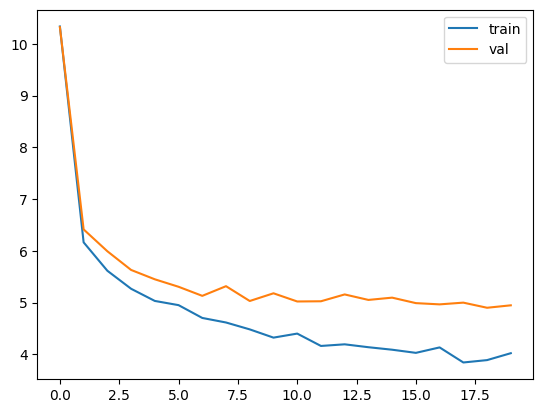

In [23]:
class SimpleFeedForwardNN_RMS_RoPE_SwiGLU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNormalization((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)
        
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )
        
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])
        
        print(f"model params: {sum([m.numel() for m in self.parameters()])}")
        
    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        
        x = self.rms(x)
        x = x + self.rope_attention(x)
        
        x = self.rms(x)
        x = x + self.linear(x)
        
        logits = self.last_linear(x)
        
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        
        else:
            return logits
        
model = SimpleFeedForwardNN_RMS_RoPE_SwiGLU(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, print_logs=True)

In [24]:
generate(model, config=MASTER_CONFIG)

["<unk> to tard O!\nIt some note? Say? speak, my waking of alive.\n\nAway hath neither;\nFor 'tw",
 "<unk>op suppers, scope they have said heir in Ros to do't,\nAnd su-night, father's hope:\n",
 "<unk>thers if you live myies,\nWas pun\nIt were they pawn were struck'd he had\nexatch her liimed",
 '<unk> tide like hearting,\nAnd I bowards: the Tit hundred dearard,\nThe doubt, or slander lightsR!',
 "<unk> royal your choice then had were great prince spoke't.\n\nDERBY:\nLook, sir, having; King Richard I know my lord"]

### Llama

So what makes Llama 2 different from regular simple feed forward networks? Blocks of RMSNorm and Residual Rope Attention. Let's make those blocks and create our model

In [59]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.rms = RMSNormalization((config['context_window'], config['d_model']))
        
        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['hidden_dim'], bias=False),
            SwiGLU(config['hidden_dim']),
            nn.Linear(config['hidden_dim'], config['hidden_dim'], bias=False),
            SwiGLU(config['hidden_dim']),
            nn.Linear(config['hidden_dim'], config['d_model'], bias=False),
            nn.Dropout(0.0)
        )
        
    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)
        
        x = self.rms(x)
        x = x + self.feedforward(x)
        return x
    
block = LlamaBlock(MASTER_CONFIG)
block(torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))

tensor([[[-0.1557,  0.0220,  0.2343,  ...,  1.5165,  0.5609,  0.2599],
         [ 0.1524,  0.2807, -1.1694,  ...,  0.1402,  0.8732, -0.1581],
         [-0.4733, -1.6318,  0.4726,  ...,  0.4484,  0.5368, -0.7287],
         ...,
         [-0.2909,  0.2342, -1.0030,  ...,  0.3930, -0.6184,  0.5347],
         [ 1.4435,  1.8753,  0.1896,  ..., -1.5523,  2.0323, -1.2782],
         [-2.2981, -1.0735, -2.0227,  ...,  3.0449,  0.5143,  0.1326]],

        [[-0.8881, -1.0305,  0.3838,  ..., -0.1182, -1.0868,  0.3203],
         [-0.9000, -0.6619, -1.9815,  ...,  0.1022, -0.1536,  1.7003],
         [ 1.3526,  0.2214, -1.8651,  ...,  1.7361, -1.3142, -0.4087],
         ...,
         [-0.0296, -1.1791, -2.1416,  ...,  0.5720, -1.7242, -0.6126],
         [-0.1943, -0.1102, -0.7509,  ...,  0.2550, -2.1761, -0.6522],
         [ 1.0739,  0.6446, -2.1420,  ..., -0.1858,  0.4377,  0.0859]],

        [[-1.3149, -0.0731,  1.5086,  ...,  0.5446,  1.5872, -1.3973],
         [-1.1374, -1.2263,  0.4381,  ...,  1

In [60]:
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )
        
        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )
        
        print(f"model params: {sum([m.numel() for m in self.parameters()])}")
        
    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)
        
        if targets is None:
            return logits
        
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

model params: 32211111
Epoch 0 | val loss 10.330 | Time 0.555 | ETA in seconds: 11.100
Epoch 50 | val loss 7.057 | Time 25.161 | ETA in seconds: 478.050
Epoch 100 | val loss 6.479 | Time 25.053 | ETA in seconds: 450.955
Epoch 150 | val loss 6.536 | Time 25.504 | ETA in seconds: 433.568
Epoch 200 | val loss 6.577 | Time 25.125 | ETA in seconds: 402.000
Epoch 250 | val loss 6.506 | Time 25.278 | ETA in seconds: 379.170
Epoch 300 | val loss 6.554 | Time 25.262 | ETA in seconds: 353.668
Epoch 350 | val loss 6.564 | Time 25.332 | ETA in seconds: 329.310
Epoch 400 | val loss 6.484 | Time 24.966 | ETA in seconds: 299.592
Epoch 450 | val loss 6.440 | Time 25.142 | ETA in seconds: 276.557
Epoch 500 | val loss 6.580 | Time 24.903 | ETA in seconds: 249.030
Epoch 550 | val loss 7.822 | Time 25.294 | ETA in seconds: 227.647
Epoch 600 | val loss 7.628 | Time 28.525 | ETA in seconds: 228.201
Epoch 650 | val loss 6.937 | Time 30.951 | ETA in seconds: 216.654
Epoch 700 | val loss 7.937 | Time 31.748 | 

<Axes: >

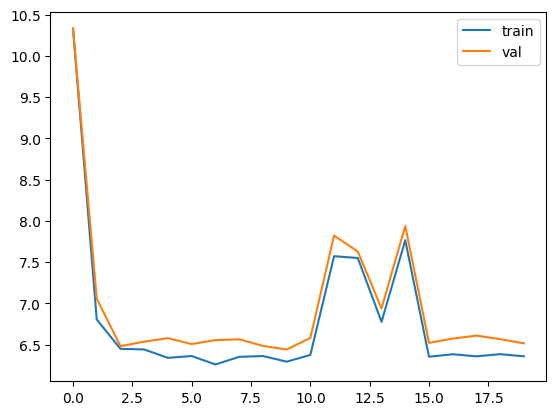

In [56]:
llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.AdamW(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG, print_logs=True)

In [61]:
MASTER_CONFIG['epochs'] = 10000
MASTER_CONFIG['batch_size'] = 128
MASTER_CONFIG['context_window'] = 256
llama = Llama(MASTER_CONFIG)

llama_optimizer = torch.optim.AdamW(
    llama.parameters(),
    betas=(.9, .95),
    weight_decay=.1,
    eps=1e-9,
    lr=5e-4,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)
train(llama, llama_optimizer, scheduler=scheduler, config=MASTER_CONFIG, print_logs=True)

KeyboardInterrupt: 

In [ ]:
generate(llama, config=MASTER_CONFIG, temperature=0.6, top_k=3, max_new_tokens=50)

In [ ]:
#Run at your own risk! Likely will not work!

LLAMA_CONFIG = {
    "vocab_size": len(vocab),
    "batch_size": 32,
    "context_window": 2048,
    "d_model": 4096,
    "epochs": 1000,
    "log_interval": 50,
    "n_heads": 32,
    "n_layers": 32,
}
llama = Llama(LLAMA_CONFIG)

llama_optimizer = torch.optim.Adam(
    llama.parameters(),
    betas=(.9, .95),
    weight_decay=.1,
    eps=1e-9,
    lr=1e-3
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)
train(llama, llama_optimizer, scheduler=scheduler, config=LLAMA_CONFIG, print_logs=True)

In [ ]:
def export(llama_model, filepath, group_size=64, dtype=torch.float32):
    """ Generate the pytorch_model.bin state_dict and config.json for HuggingFace """

    try:
        from transformers.models.llama.configuration_llama import LlamaConfig
        import os
    except ImportError:
        print("Please run `pip install transformers` to install it")
        return None

    # Generate LlamaModel state_dict
    hf_state_dict = {}

    # Sometimes we have repeated key values for the heads
    dim = llama_model.params.dim
    num_key_value_heads = llama_model.params.n_kv_heads
    n_rep = llama_model.params.n_heads // num_key_value_heads
    key_value_dim = dim // n_rep

    # HuggingFace needs the weights permuted.
    # See: https://github.com/huggingface/transformers/blob/b132c1703eb1c8bd9dfa4ad6a9be2bfd6ef819e9/src/transformers/models/llama/convert_llama_weights_to_hf.py#L122
    def permute_original(w, n_heads=llama_model.params.n_heads, dim1=dim, dim2=dim):
        return w.view(dim1, dim2).reshape(n_heads, dim1 // n_heads // 2, 2, dim2).transpose(1, 2).reshape(dim1, dim2)

    # Transfer weights from llama model to the HF state dictionary format
    hf_state_dict['model.embed_tokens.weight'] = llama_model.tok_embeddings.weight.clone().to(dtype)
    hf_state_dict['model.norm.weight'] = llama_model.norm.weight.clone().to(dtype)

    # Add each layer's weights to the HF state dictionary
    for i, layer in enumerate(llama_model.layers):
        layer_id = layer.layer_id
        hf_state_dict[f'model.layers.{i}.input_layernorm.weight'] = llama_model.layers[layer_id].attention_norm.weight.clone().to(dtype)
        hf_state_dict[f'model.layers.{i}.self_attn.q_proj.weight'] = permute_original(llama_model.layers[layer_id].attention.wq.weight.clone()).to(dtype)
        hf_state_dict[f'model.layers.{i}.self_attn.k_proj.weight'] = permute_original(llama_model.layers[layer_id].attention.wk.weight.clone(), num_key_value_heads, key_value_dim, dim).to(dtype)
        hf_state_dict[f'model.layers.{i}.self_attn.v_proj.weight'] = llama_model.layers[layer_id].attention.wv.weight.clone().to(dtype)
        hf_state_dict[f'model.layers.{i}.self_attn.o_proj.weight'] = llama_model.layers[layer_id].attention.wo.weight.clone().to(dtype)
        hf_state_dict[f'model.layers.{i}.post_attention_layernorm.weight'] = llama_model.layers[layer_id].ffn_norm.weight.clone().to(dtype)
        hf_state_dict[f'model.layers.{i}.mlp.gate_proj.weight'] = llama_model.layers[layer_id].feed_forward.w1.weight.clone().to(dtype)
        hf_state_dict[f'model.layers.{i}.mlp.down_proj.weight'] = llama_model.layers[layer_id].feed_forward.w2.weight.clone().to(dtype)
        hf_state_dict[f'model.layers.{i}.mlp.up_proj.weight'] = llama_model.layers[layer_id].feed_forward.w3.weight.clone().to(dtype)

    # llama2.c usually uses tied weights -> reference the embed_tokens.weights instead
    hf_state_dict['lm_head.weight'] = hf_state_dict['model.embed_tokens.weight']

    # We check that the embeddings are tied, else use manual output weights
    _embeddings_are_tied: bool = torch.equal(llama_model.tok_embeddings.weight, llama_model.output.weight)
    if not _embeddings_are_tied:
        hf_state_dict['lm_head.weight'] = llama_model.output.weight.clone().to(dtype)


    # Generate LlamaConfig (seen in transformers.models.llama.configuration_llama)

    # Extract necessary attributes from llama.c model
    vocab_size = llama_model.params.vocab_size
    hidden_size = llama_model.params.dim
    intermediate_size = llama_model.layers[0].feed_forward.w1.weight.shape[0]
    num_hidden_layers = llama_model.params.n_layers
    num_attention_heads = llama_model.params.n_heads
    num_key_value_heads = llama_model.params.n_kv_heads
    max_position_embeddings = llama_model.params.max_seq_len
    rms_norm_eps = llama_model.params.norm_eps

    config = LlamaConfig(
        vocab_size=vocab_size,
        hidden_size=hidden_size,
        intermediate_size=intermediate_size,
        num_hidden_layers=num_hidden_layers,
        num_attention_heads=num_attention_heads,
        num_key_value_heads=num_key_value_heads,
        max_position_embeddings=max_position_embeddings,
        rms_norm_eps=rms_norm_eps,
        tie_word_embeddings=_embeddings_are_tied,
        # Manual
        architectures=["LlamaForCausalLM"],
        hidden_act="silu",
    )


    # Save files in directory filepath
    # First make the directory if it doesn't exist
    os.makedirs(filepath, exist_ok=True)

    # Save the state dictionary in .bin format, and config as .json
    torch.save(hf_state_dict, os.path.join(filepath, "pytorch_model.bin"))
    config.save_pretrained(filepath)
    
export(llama, "./llama2/")